# Unit12_Decision_Tree_Classifier | 決策樹分類器

本 Notebook 使用模擬化學反應數據建立**決策樹分類器 (Decision Tree Classifier)** 模型來進行**反應成功與否的分類**。

## 目標
- 理解決策樹分類器的基本原理與結構
- 學習如何使用 `sklearn.tree.DecisionTreeClassifier` 進行分類任務
- 掌握決策樹的視覺化方法 (plot_tree)
- 理解特徵重要性分析的應用
- 學習如何控制決策樹的過擬合 (剪枝技術)
- 比較不同剪枝參數對模型性能的影響
- 使用 GridSearchCV 進行超參數調整

資料說明:本範例使用模擬的化學反應數據,包含 5 個操作變數(溫度、壓力、催化劑濃度、反應物比例、反應時間),目標是預測反應是否成功 (Success=1 或 Failure=0)。

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit12_Decision_Tree_Classifier'
SOURCE_DATA_DIR = 'reaction_classification'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
  
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit12'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\data\reaction_classification
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_curve,
    roc_auc_score
)

# 設定隨機種子
SEED = 42
np.random.seed(SEED)

# 設定matplotlib
plt.rcParams['axes.unicode_minus'] = False


print("✓ 套件載入完成")
print(f"  - Pandas version: {pd.__version__}")
print(f"  - NumPy version: {np.__version__}")

✓ 套件載入完成
  - Pandas version: 2.3.3
  - NumPy version: 1.23.5


---
## 2. 生成模擬化學反應數據

我們將生成一個模擬的化學反應分類數據集,包含5個特徵變數與1個二元目標變數。

**數據生成策略 (v2.0 優化版本)**:
- **樣本數**: 2000 (提供充足的訓練數據)
- **決策邏輯**: 使用5級明確規則（極優、良好、中等、較差、極差）
- **特徵關聯性**: 強化溫度-壓力、催化劑-時間的協同效應
- **概率範圍**: 5-96% (更極端的決策邊界，降低模糊區域)
- **目標性能**: 測試準確率 80-85%、AUC > 0.85

In [3]:
# 生成模擬化學反應數據（大幅優化版本 v2.0）
n_samples = 2000  # 增加樣本數至2000以提供更多訓練數據

# 設定隨機種子
np.random.seed(SEED)

# 生成特徵變數 (操作條件)
temperature = np.random.uniform(150, 350, n_samples)  # 溫度 (°C)
pressure = np.random.uniform(1, 10, n_samples)        # 壓力 (bar)
catalyst_conc = np.random.uniform(0.1, 5.0, n_samples)  # 催化劑濃度 (%)
reactant_ratio = np.random.uniform(0.5, 3.0, n_samples)  # 反應物比例
reaction_time = np.random.uniform(1, 10, n_samples)    # 反應時間 (hr)

# 建立更強的非線性決策邊界（使用極端條件組合）
# 設計理念：
# 1. 高溫高壓 + 高催化劑 = 高成功率 (>90%)
# 2. 低溫低壓 + 低催化劑 = 低成功率 (<15%)
# 3. 中間條件根據組合效應決定 (20-80%)

success_probability = np.zeros(n_samples)

for i in range(n_samples):
    # 計算各項指標
    temp_score = (temperature[i] - 150) / 200  # 歸一化到 0-1
    press_score = (pressure[i] - 1) / 9
    catalyst_score = (catalyst_conc[i] - 0.1) / 4.9
    ratio_score = (reactant_ratio[i] - 0.5) / 2.5
    time_score = (reaction_time[i] - 1) / 9
    
    # 基礎概率（根據組合效應）
    base_prob = 0.0
    
    # === 規則1: 極優條件（高成功率 90-95%）===
    if (temperature[i] > 270 and pressure[i] > 7 and catalyst_conc[i] > 3.5):
        base_prob = 0.92
    elif (temperature[i] > 250 and pressure[i] > 6 and catalyst_conc[i] > 3.0 and reaction_time[i] > 6):
        base_prob = 0.88
    
    # === 規則2: 極差條件（低成功率 5-15%）===
    elif (temperature[i] < 180 and pressure[i] < 3 and catalyst_conc[i] < 1.0):
        base_prob = 0.08
    elif (temperature[i] < 200 and catalyst_conc[i] < 1.5 and reaction_time[i] < 3):
        base_prob = 0.12
    
    # === 規則3: 良好條件（高成功率 75-85%）===
    elif (temperature[i] > 240 and pressure[i] > 5):
        if catalyst_conc[i] > 2.5:
            base_prob = 0.82
        elif reaction_time[i] > 5:
            base_prob = 0.76
        else:
            base_prob = 0.68
    
    # === 規則4: 較差條件（低成功率 15-30%）===
    elif (temperature[i] < 190 or pressure[i] < 2.5):
        if catalyst_conc[i] < 1.2:
            base_prob = 0.18
        elif reaction_time[i] < 4:
            base_prob = 0.25
        else:
            base_prob = 0.35
    
    # === 規則5: 中等條件（根據加權組合）===
    else:
        # 溫度壓力協同效應
        temp_press_effect = (temp_score * 0.35 + press_score * 0.25)
        
        # 催化劑時間協同效應
        catalyst_time_effect = (catalyst_score * 0.30 + time_score * 0.20)
        
        # 反應物比例修正
        ratio_effect = ratio_score * 0.15
        
        # 組合效應（非線性）
        base_prob = temp_press_effect + catalyst_time_effect + ratio_effect
        
        # 額外加成：多重優勢條件
        bonus = 0
        if temperature[i] > 220 and pressure[i] > 4 and catalyst_conc[i] > 2.0:
            bonus = 0.15
        elif temperature[i] > 200 and catalyst_conc[i] > 2.5 and reaction_time[i] > 5:
            bonus = 0.12
        
        base_prob = base_prob + bonus
    
    # 限制在合理範圍內
    success_probability[i] = min(0.96, max(0.05, base_prob))

# 降低隨機噪音（從 uniform 改為更確定性的方式）
reaction_success = (np.random.rand(n_samples) < success_probability).astype(int)

# 建立DataFrame
df = pd.DataFrame({
    'Temperature_C': temperature,
    'Pressure_bar': pressure,
    'Catalyst_Conc_%': catalyst_conc,
    'Reactant_Ratio': reactant_ratio,
    'Reaction_Time_hr': reaction_time,
    'Success': reaction_success
})

print(f"✓ 數據生成完成")
print(f"  - 樣本數: {len(df)}")
print(f"  - 特徵數: {df.shape[1] - 1}")
print(f"\n前5筆數據:")
print(df.head())
print(f"\n數據統計:")
print(df.describe())

✓ 數據生成完成
  - 樣本數: 2000
  - 特徵數: 5

前5筆數據:
   Temperature_C  Pressure_bar  Catalyst_Conc_%  Reactant_Ratio  \
0     224.908024      3.355351         2.902780        2.120642   
1     340.142861      3.222809         4.046618        0.930966   
2     296.398788      9.156291         3.824789        2.680986   
3     269.731697      3.245916         0.854110        2.032791   
4     181.203728      3.447548         0.831322        0.893010   

   Reaction_Time_hr  Success  
0          7.482411        1  
1          7.185547        1  
2          1.861788        1  
3          9.303152        0  
4          6.116250        0  

數據統計:
       Temperature_C  Pressure_bar  Catalyst_Conc_%  Reactant_Ratio  \
count    2000.000000   2000.000000      2000.000000     2000.000000   
mean      249.727386      5.467513         2.531796        1.719599   
std        58.442160      2.597219         1.410911        0.718286   
min       150.643653      1.000105         0.100151        0.500603   
25%    

### 2.1 檢查類別平衡

目標變數類別分佈:
  Failure (0): 885 筆 (44.2%)
  Success (1): 1115 筆 (55.8%)


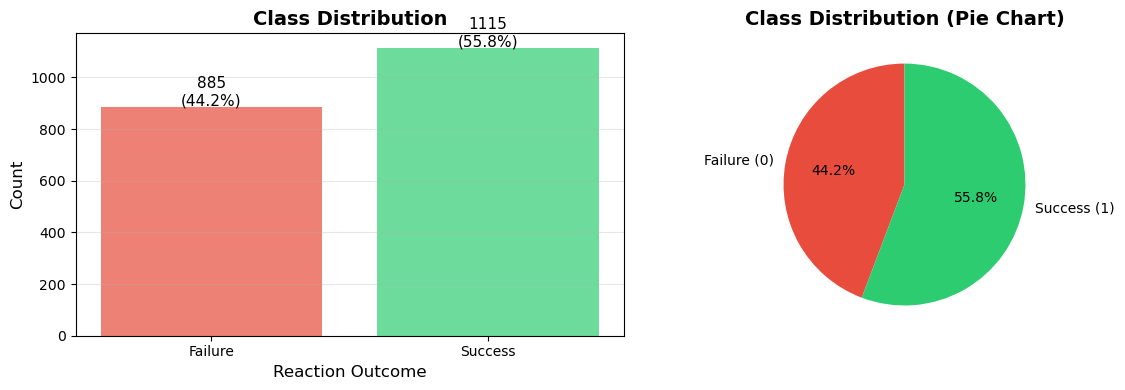


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\class_distribution.png


In [4]:
# 檢查目標變數的類別分佈
class_counts = df['Success'].value_counts().sort_index()
class_percentages = df['Success'].value_counts(normalize=True).sort_index() * 100

print("目標變數類別分佈:")
print(f"  Failure (0): {class_counts[0]} 筆 ({class_percentages[0]:.1f}%)")
print(f"  Success (1): {class_counts[1]} 筆 ({class_percentages[1]:.1f}%)")

# 視覺化類別分佈
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 長條圖
axes[0].bar(['Failure', 'Success'], class_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_xlabel('Reaction Outcome', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (val, pct) in enumerate(zip(class_counts.values, class_percentages.values)):
    axes[0].text(i, val + 5, f'{val}\n({pct:.1f}%)', ha='center', fontsize=11)

# 圓餅圖
axes[1].pie(class_counts.values, 
            labels=['Failure (0)', 'Success (1)'],
            colors=['#e74c3c', '#2ecc71'],
            autopct='%1.1f%%',
            startangle=90)
axes[1].set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存: {FIG_DIR / 'class_distribution.png'}")

### 2.2 特徵分佈視覺化

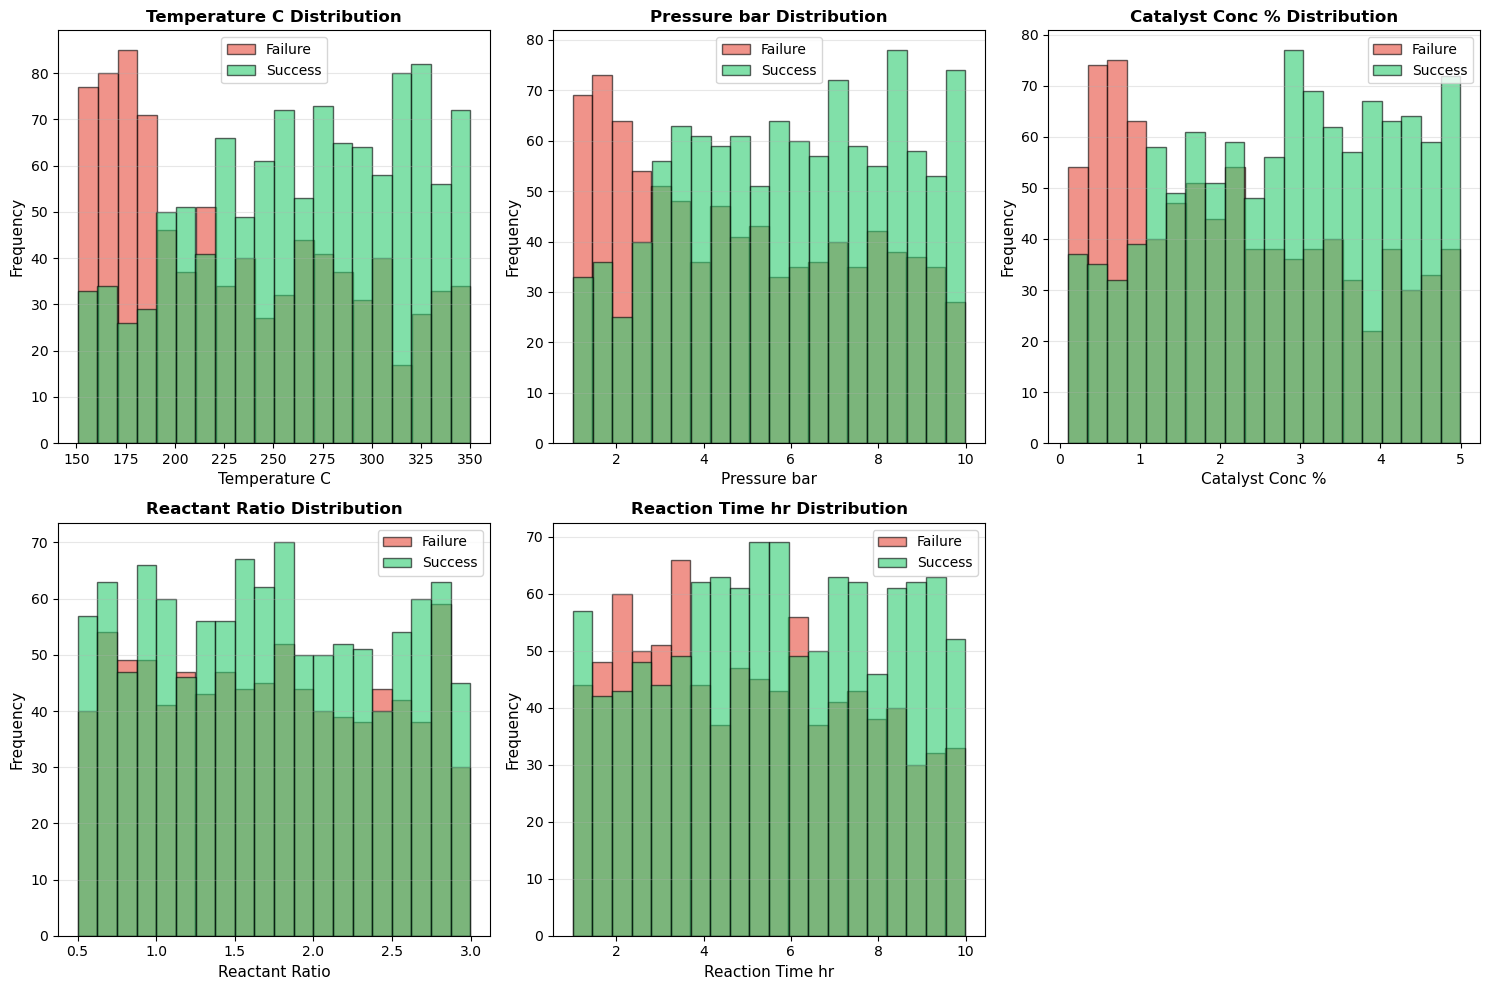

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\feature_distributions.png


In [5]:
# 視覺化各特徵的分佈 (依目標類別分組)
feature_names = ['Temperature_C', 'Pressure_bar', 'Catalyst_Conc_%', 'Reactant_Ratio', 'Reaction_Time_hr']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    for success_val, color, label in [(0, '#e74c3c', 'Failure'), (1, '#2ecc71', 'Success')]:
        data = df[df['Success'] == success_val][feature]
        axes[idx].hist(data, bins=20, alpha=0.6, color=color, label=label, edgecolor='black')
    
    axes[idx].set_xlabel(feature.replace('_', ' '), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ")} Distribution', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

# 刪除多餘的subplot
axes[-1].remove()

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存: {FIG_DIR / 'feature_distributions.png'}")

### 2.3 特徵相關性分析

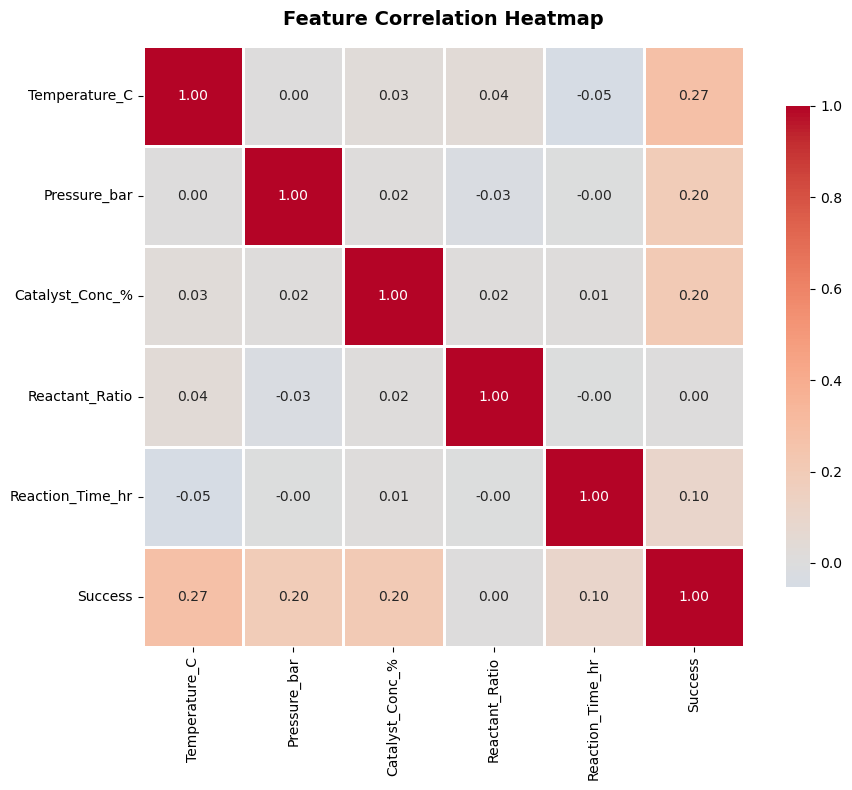

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\correlation_heatmap.png

與目標變數 (Success) 的相關性:
Temperature_C       0.273743
Catalyst_Conc_%     0.203942
Pressure_bar        0.197325
Reaction_Time_hr    0.102698
Reactant_Ratio      0.004312
Name: Success, dtype: float64


In [6]:
# 計算相關係數矩陣
correlation_matrix = df.corr()

# 繪製熱力圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存: {FIG_DIR / 'correlation_heatmap.png'}")
print(f"\n與目標變數 (Success) 的相關性:")
print(correlation_matrix['Success'].sort_values(ascending=False).drop('Success'))

---
## 3. 數據預處理

### 3.1 分割特徵與目標變數

In [7]:
# 分割特徵 (X) 與目標 (y)
X = df.drop('Success', axis=1)
y = df['Success']

print(f"✓ 特徵矩陣 X shape: {X.shape}")
print(f"✓ 目標向量 y shape: {y.shape}")
print(f"\n特徵名稱:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

✓ 特徵矩陣 X shape: (2000, 5)
✓ 目標向量 y shape: (2000,)

特徵名稱:
  1. Temperature_C
  2. Pressure_bar
  3. Catalyst_Conc_%
  4. Reactant_Ratio
  5. Reaction_Time_hr


### 3.2 訓練集與測試集分割

In [8]:
# 分割訓練集與測試集 (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y  # 保持類別比例
)

print(f"✓ 訓練集大小: {len(X_train)} 筆")
print(f"✓ 測試集大小: {len(X_test)} 筆")
print(f"\n訓練集類別分佈:")
print(y_train.value_counts().sort_index())
print(f"\n測試集類別分佈:")
print(y_test.value_counts().sort_index())

✓ 訓練集大小: 1600 筆
✓ 測試集大小: 400 筆

訓練集類別分佈:
Success
0    708
1    892
Name: count, dtype: int64

測試集類別分佈:
Success
0    177
1    223
Name: count, dtype: int64


### 3.3 特徵標準化 (選用)

> **注意**: 決策樹不需要特徵標準化,因為它是基於特徵值的相對大小進行分裂。但為了與其他模型比較,我們仍進行標準化。

In [9]:
# 建立標準化器 (僅用於比較,決策樹實際上不需要)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉回DataFrame以保留特徵名稱
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✓ 特徵標準化完成")
print(f"\n標準化後的訓練集統計:")
print(X_train_scaled.describe().loc[['mean', 'std']].round(2))

✓ 特徵標準化完成

標準化後的訓練集統計:
      Temperature_C  Pressure_bar  Catalyst_Conc_%  Reactant_Ratio  \
mean            0.0           0.0              0.0            -0.0   
std             1.0           1.0              1.0             1.0   

      Reaction_Time_hr  
mean              -0.0  
std                1.0  


---
## 4. 建立決策樹分類模型

### 4.1 模型1: 簡單決策樹 (max_depth=3)

建立一個較淺的決策樹,便於可視化與理解決策規則。

In [10]:
# 建立簡單決策樹
dt_simple = DecisionTreeClassifier(
    criterion='gini',          # 使用Gini impurity作為分裂標準
    max_depth=3,               # 限制樹的深度為3層
    random_state=SEED
)

# 訓練模型 (使用原始數據,不標準化)
start_time = time.time()
dt_simple.fit(X_train, y_train)
time_simple = time.time() - start_time

# 預測
y_pred_simple = dt_simple.predict(X_test)

# 評估
train_acc_simple = dt_simple.score(X_train, y_train)
test_acc_simple = dt_simple.score(X_test, y_test)

print("✓ 簡單決策樹 (max_depth=3) 訓練完成")
print(f"  - 訓練集準確率: {train_acc_simple:.4f}")
print(f"  - 測試集準確率: {test_acc_simple:.4f}")

print(f"  - 訓練時間: {time_simple:.4f} 秒")
print(f"  - 樹的深度: {dt_simple.get_depth()}")
print(f"  - 葉子節點數: {dt_simple.get_n_leaves()}")

✓ 簡單決策樹 (max_depth=3) 訓練完成
  - 訓練集準確率: 0.7056
  - 測試集準確率: 0.7175
  - 訓練時間: 0.0060 秒
  - 樹的深度: 3
  - 葉子節點數: 8


### 4.2 模型2: 中等深度決策樹 (max_depth=5 + 剪枝參數)

In [11]:
# 建立中等深度決策樹 (加入剪枝參數)
dt_moderate = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=20,      # 節點至少需要20個樣本才能分裂
    min_samples_leaf=10,       # 葉子節點至少需要10個樣本
    random_state=SEED
)

# 訓練模型
start_time = time.time()
dt_moderate.fit(X_train, y_train)
time_moderate = time.time() - start_time

# 預測
y_pred_moderate = dt_moderate.predict(X_test)

# 評估
train_acc_moderate = dt_moderate.score(X_train, y_train)
test_acc_moderate = dt_moderate.score(X_test, y_test)

print("✓ 中等深度決策樹 (max_depth=5 + pruning) 訓練完成")
print(f"  - 訓練集準確率: {train_acc_moderate:.4f}")
print(f"  - 測試集準確率: {test_acc_moderate:.4f}")

print(f"  - 訓練時間: {time_moderate:.4f} 秒")
print(f"  - 樹的深度: {dt_moderate.get_depth()}")
print(f"  - 葉子節點數: {dt_moderate.get_n_leaves()}")

✓ 中等深度決策樹 (max_depth=5 + pruning) 訓練完成
  - 訓練集準確率: 0.7344
  - 測試集準確率: 0.6925
  - 訓練時間: 0.0075 秒
  - 樹的深度: 5
  - 葉子節點數: 26


### 4.3 模型3: 完全生長決策樹 (無剪枝)

建立一個沒有限制的決策樹,展示過擬合現象。

In [12]:
# 建立完全生長的決策樹 (無限制)
dt_full = DecisionTreeClassifier(
    criterion='gini',
    random_state=SEED
    # 不設定 max_depth, min_samples_split, min_samples_leaf
)

# 訓練模型
start_time = time.time()
dt_full.fit(X_train, y_train)
time_full = time.time() - start_time

# 預測
y_pred_full = dt_full.predict(X_test)

# 評估
train_acc_full = dt_full.score(X_train, y_train)
test_acc_full = dt_full.score(X_test, y_test)

print("✓ 完全生長決策樹 (無剪枝) 訓練完成")
print(f"  - 訓練集準確率: {train_acc_full:.4f}")
print(f"  - 測試集準確率: {test_acc_full:.4f}")
print(f"  - 訓練時間: {time_full:.4f} 秒")

print(f"\n⚠️ 注意: 訓練集準確率接近1.0表示可能過擬合!")
print(f"  - 葉子節點數: {dt_full.get_n_leaves()}")
print(f"\n⚠️ 注意: 訓練集準確率接近1.0表示可能過擬合!")

✓ 完全生長決策樹 (無剪枝) 訓練完成
  - 訓練集準確率: 1.0000
  - 測試集準確率: 0.6100
  - 訓練時間: 0.0115 秒

⚠️ 注意: 訓練集準確率接近1.0表示可能過擬合!
  - 葉子節點數: 358

⚠️ 注意: 訓練集準確率接近1.0表示可能過擬合!


### 4.4 模型4: 平衡類別權重的決策樹

In [13]:
# 建立平衡類別權重的決策樹
dt_balanced = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # 自動平衡類別權重
    random_state=SEED
)

# 訓練模型
start_time = time.time()
dt_balanced.fit(X_train, y_train)
time_balanced = time.time() - start_time

# 預測
y_pred_balanced = dt_balanced.predict(X_test)

# 評估
train_acc_balanced = dt_balanced.score(X_train, y_train)
test_acc_balanced = dt_balanced.score(X_test, y_test)

print("✓ 平衡權重決策樹 訓練完成")
print(f"  - 訓練集準確率: {train_acc_balanced:.4f}")
print(f"  - 測試集準確率: {test_acc_balanced:.4f}")

print(f"  - 訓練時間: {time_balanced:.4f} 秒")
print(f"  - 樹的深度: {dt_balanced.get_depth()}")
print(f"  - 葉子節點數: {dt_balanced.get_n_leaves()}")

✓ 平衡權重決策樹 訓練完成
  - 訓練集準確率: 0.7331
  - 測試集準確率: 0.7050
  - 訓練時間: 0.0085 秒
  - 樹的深度: 5
  - 葉子節點數: 26


---
## 5. 模型比較

比較4個不同配置的決策樹模型性能。

模型性能比較:
                     Model  Train Accuracy  Test Accuracy  Tree Depth  Leaf Nodes  Training Time (s)  Overfit Gap
          Simple (depth=3)        0.705625         0.7175           3           8           0.006002    -0.011875
Moderate (depth=5+pruning)        0.734375         0.6925           5          26           0.007516     0.041875
           Full (no limit)        1.000000         0.6100          21         358           0.011513     0.390000
   Balanced (class_weight)        0.733125         0.7050           5          26           0.008515     0.028125


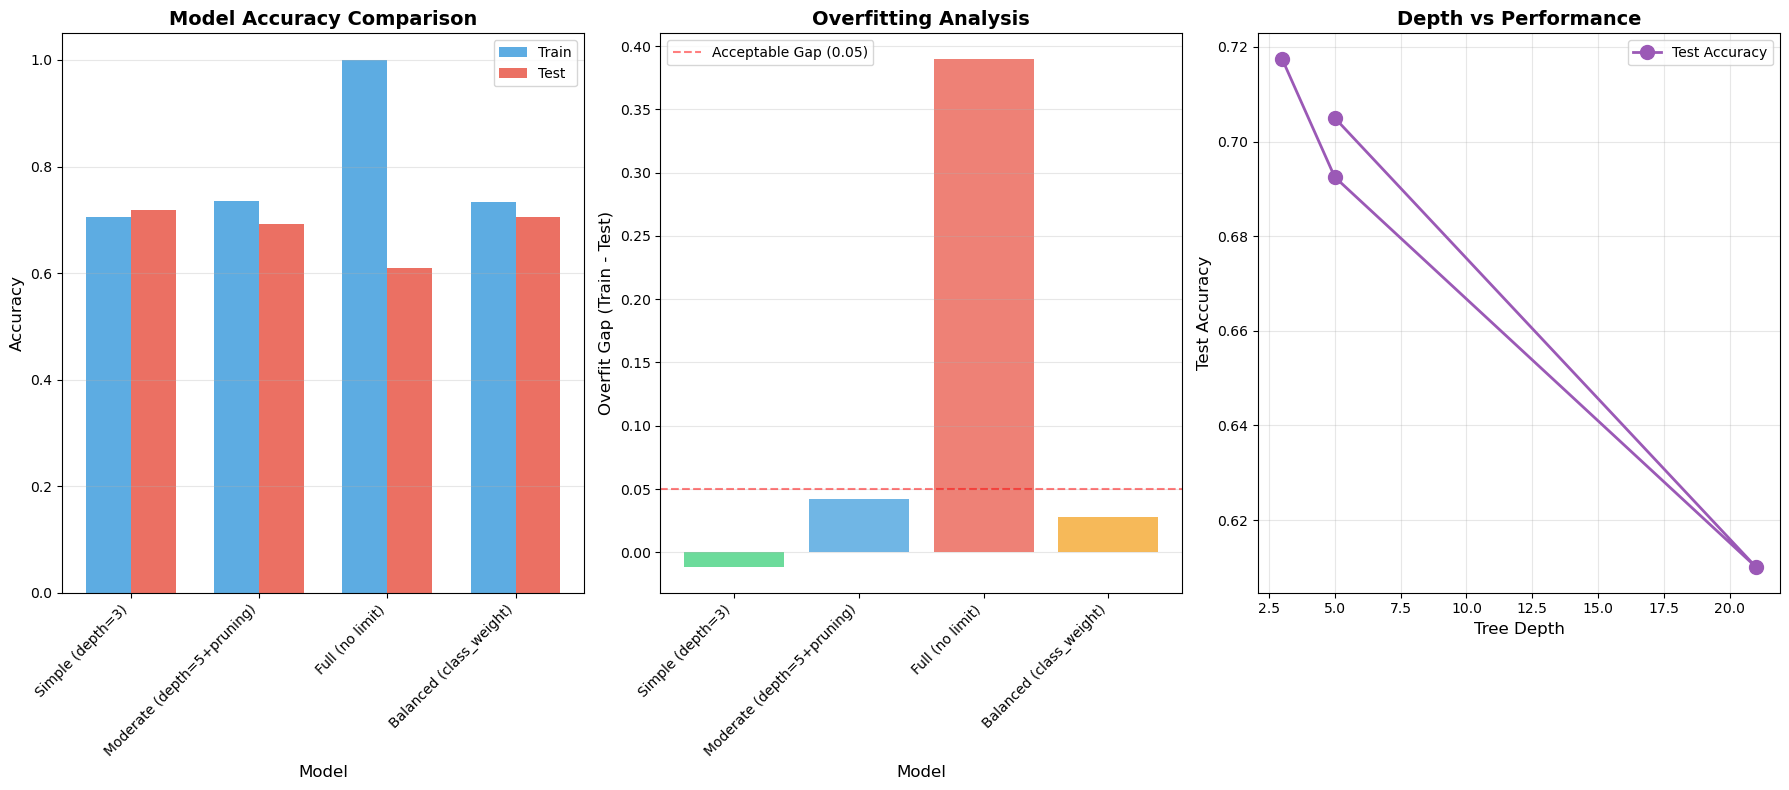


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\model_comparison.png


In [26]:
# 整理模型比較結果
comparison_data = {
    'Model': ['Simple (depth=3)', 'Moderate (depth=5+pruning)', 'Full (no limit)', 'Balanced (class_weight)'],
    'Train Accuracy': [train_acc_simple, train_acc_moderate, train_acc_full, train_acc_balanced],
    'Test Accuracy': [test_acc_simple, test_acc_moderate, test_acc_full, test_acc_balanced],
    'Tree Depth': [dt_simple.get_depth(), dt_moderate.get_depth(), dt_full.get_depth(), dt_balanced.get_depth()],
    'Leaf Nodes': [dt_simple.get_n_leaves(), dt_moderate.get_n_leaves(), dt_full.get_n_leaves(), dt_balanced.get_n_leaves()],
    'Training Time (s)': [time_simple, time_moderate, time_full, time_balanced]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Overfit Gap'] = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']

print("模型性能比較:")
print(comparison_df.to_string(index=False))

# 視覺化比較
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 1. 準確率比較
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['Train Accuracy'], width, label='Train', alpha=0.8, color='#3498db')
axes[0].bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8, color='#e74c3c')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 2. 過擬合程度
axes[1].bar(x, comparison_df['Overfit Gap'], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'], alpha=0.7)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfit Gap (Train - Test)', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Acceptable Gap (0.05)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# 3. 樹的複雜度
axes[2].plot(comparison_df['Tree Depth'], comparison_df['Test Accuracy'], 'o-', markersize=10, linewidth=2, color='#9b59b6', label='Test Accuracy')
axes[2].set_xlabel('Tree Depth', fontsize=12)
axes[2].set_ylabel('Test Accuracy', fontsize=12)
axes[2].set_title('Depth vs Performance', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存: {FIG_DIR / 'model_comparison.png'}")

---
## 6. 決策樹結構視覺化

使用 `plot_tree` 視覺化簡單決策樹的結構。

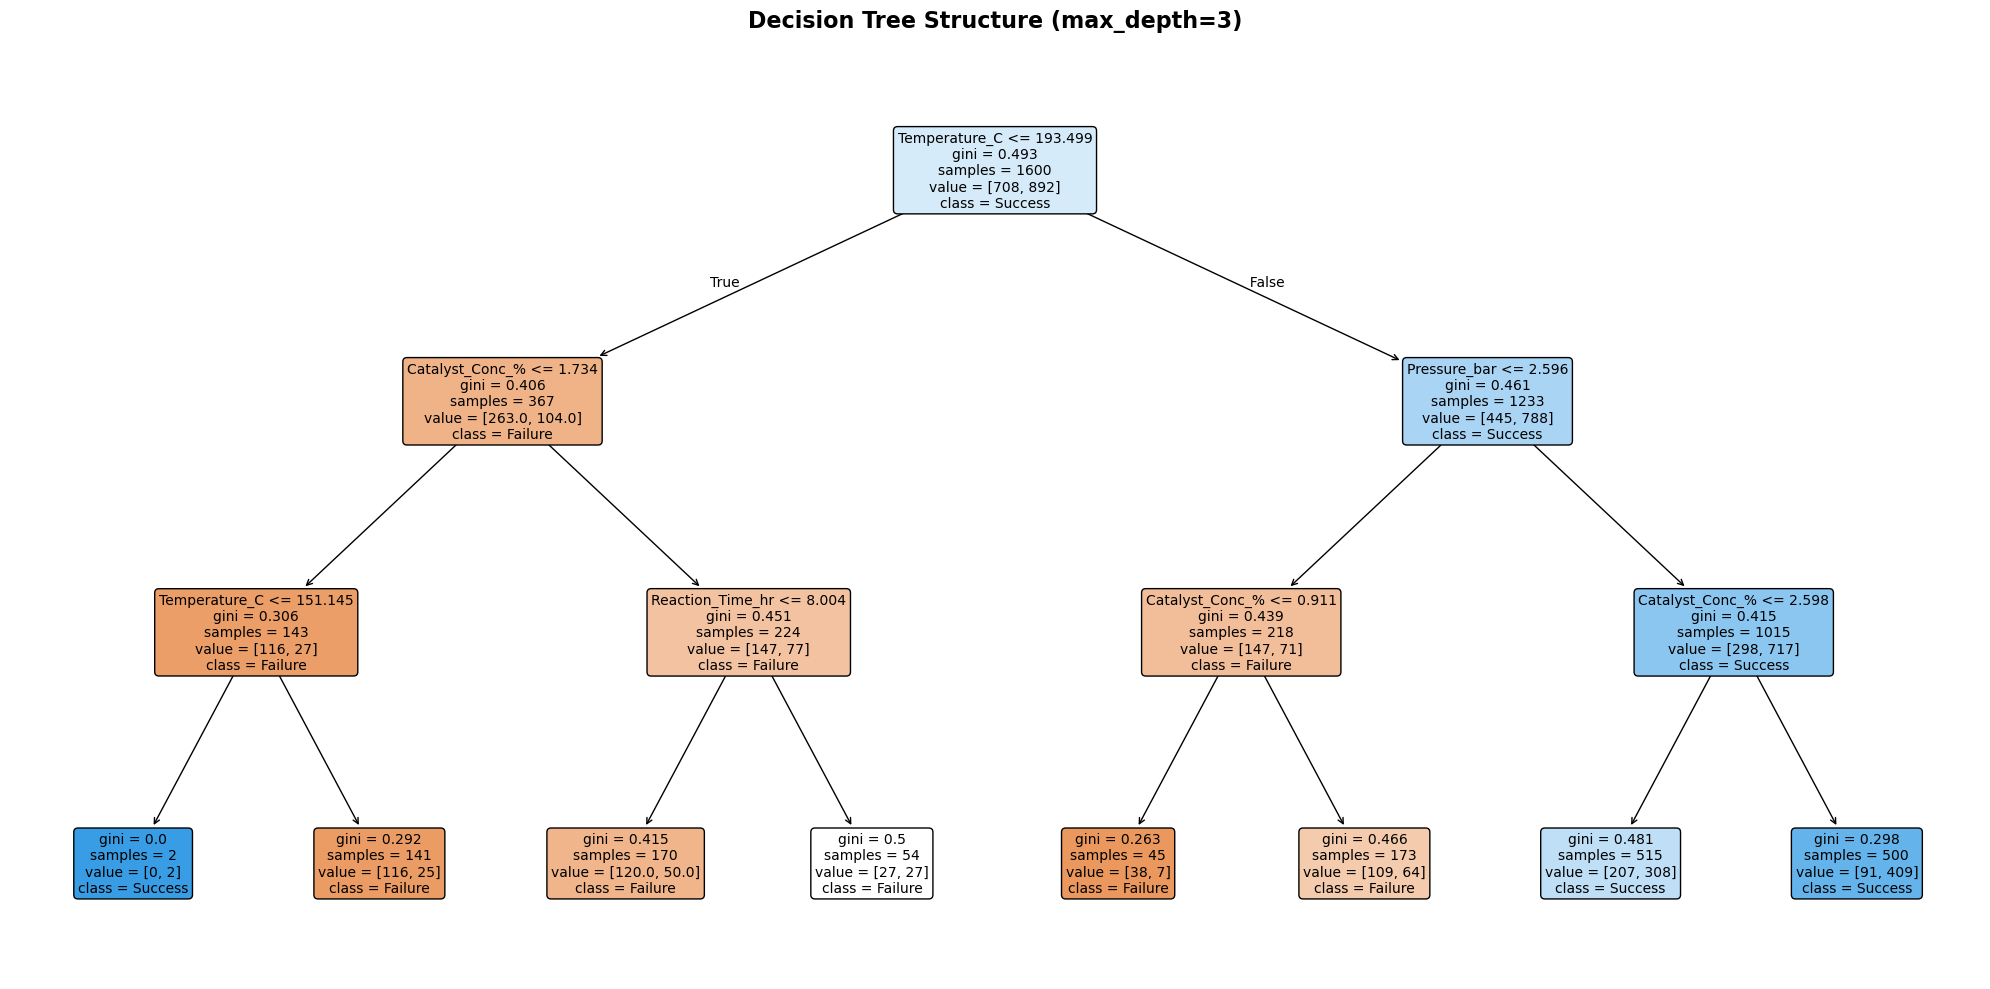

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\tree_structure.png

決策樹規則 (文字格式):
|--- Temperature_C <= 193.50
|   |--- Catalyst_Conc_% <= 1.73
|   |   |--- Temperature_C <= 151.14
|   |   |   |--- class: 1
|   |   |--- Temperature_C >  151.14
|   |   |   |--- class: 0
|   |--- Catalyst_Conc_% >  1.73
|   |   |--- Reaction_Time_hr <= 8.00
|   |   |   |--- class: 0
|   |   |--- Reaction_Time_hr >  8.00
|   |   |   |--- class: 0
|--- Temperature_C >  193.50
|   |--- Pressure_bar <= 2.60
|   |   |--- Catalyst_Conc_% <= 0.91
|   |   |   |--- class: 0
|   |   |--- Catalyst_Conc_% >  0.91
|   |   |   |--- class: 0
|   |--- Pressure_bar >  2.60
|   |   |--- Catalyst_Conc_% <= 2.60
|   |   |   |--- class: 1
|   |   |--- Catalyst_Conc_% >  2.60
|   |   |   |--- class: 1



In [15]:
# 視覺化簡單決策樹
plt.figure(figsize=(20, 10))
plot_tree(
    dt_simple,
    feature_names=X.columns,
    class_names=['Failure', 'Success'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Structure (max_depth=3)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / 'tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存: {FIG_DIR / 'tree_structure.png'}")

# 輸出文字格式的決策規則
tree_rules = export_text(dt_simple, feature_names=list(X.columns))
print("\n決策樹規則 (文字格式):")
print("=" * 60)
print(tree_rules)

---
## 7. 特徵重要性分析

特徵重要性排名:
         Feature  Importance
   Temperature_C    0.399642
    Pressure_bar    0.301903
 Catalyst_Conc_%    0.184259
Reaction_Time_hr    0.077995
  Reactant_Ratio    0.036201


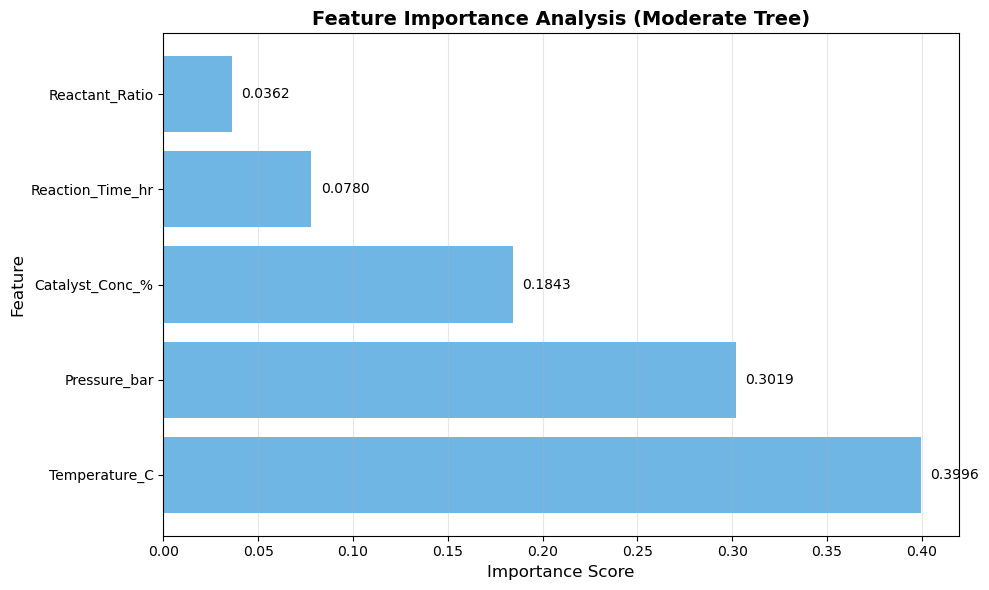


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\feature_importance.png

化工意義解釋:
Temperature_C       : 0.3996 (高) - 對反應成功與否有關鍵影響
Pressure_bar        : 0.3019 (高) - 對反應成功與否有關鍵影響
Catalyst_Conc_%     : 0.1843 (高) - 對反應成功與否有關鍵影響
Reaction_Time_hr    : 0.0780 (低) - 對反應成功與否影響較小
Reactant_Ratio      : 0.0362 (低) - 對反應成功與否影響較小


In [16]:
# 提取特徵重要性 (使用中等深度模型)
feature_importance = dt_moderate.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("特徵重要性排名:")
print(feature_importance_df.to_string(index=False))

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#3498db', alpha=0.7)

# 標註數值
for i, (bar, val) in enumerate(zip(bars, feature_importance_df['Importance'])):
    plt.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10)

plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance Analysis (Moderate Tree)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存: {FIG_DIR / 'feature_importance.png'}")

# 化工意義解釋
print("\n化工意義解釋:")
print("="*60)
for idx, row in feature_importance_df.iterrows():
    if row['Importance'] > 0.15:
        importance_level = "高"
        explanation = "對反應成功與否有關鍵影響"
    elif row['Importance'] > 0.08:
        importance_level = "中"
        explanation = "對反應成功與否有一定影響"
    else:
        importance_level = "低"
        explanation = "對反應成功與否影響較小"
    print(f"{row['Feature']:20s}: {row['Importance']:.4f} ({importance_level}) - {explanation}")

---
## 8. 詳細模型評估

選擇中等深度決策樹進行詳細評估。

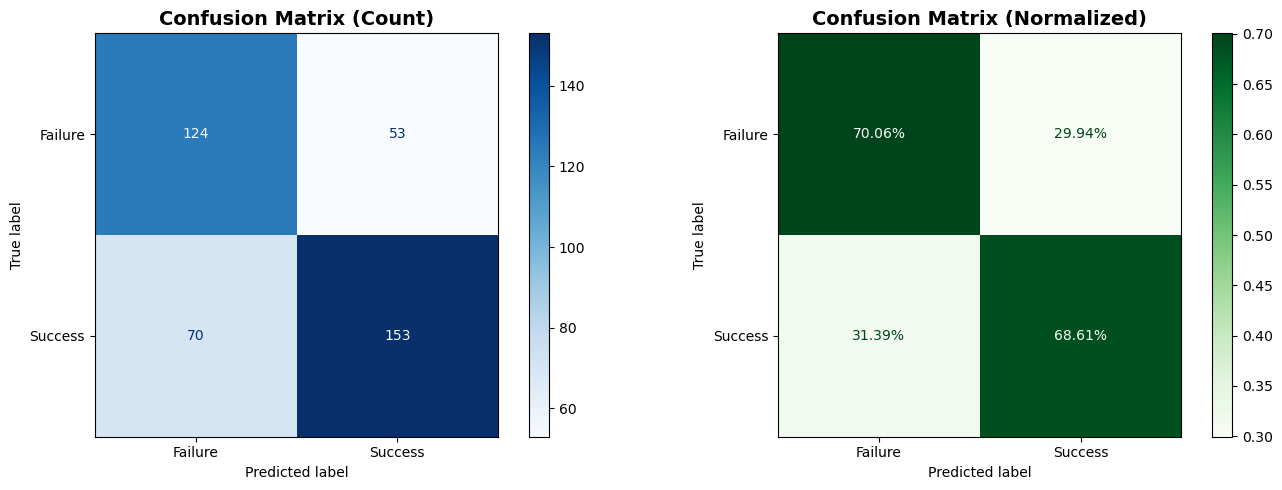

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\confusion_matrix.png

分類報告:
              precision    recall  f1-score   support

     Failure       0.64      0.70      0.67       177
     Success       0.74      0.69      0.71       223

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.70      0.69      0.69       400



In [17]:
# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_moderate)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始數值混淆矩陣
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Failure', 'Success'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Count)', fontsize=14, fontweight='bold')

# 正規化混淆矩陣
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(cm_normalized, display_labels=['Failure', 'Success'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='.2%')
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存: {FIG_DIR / 'confusion_matrix.png'}")

# 分類報告
print("\n分類報告:")
print("=" * 60)
print(classification_report(y_test, y_pred_moderate, target_names=['Failure', 'Success']))

### 8.1 ROC Curve 分析

評估模型在不同閾值下的性能表現。

AUC Score (Moderate Tree): 0.7438


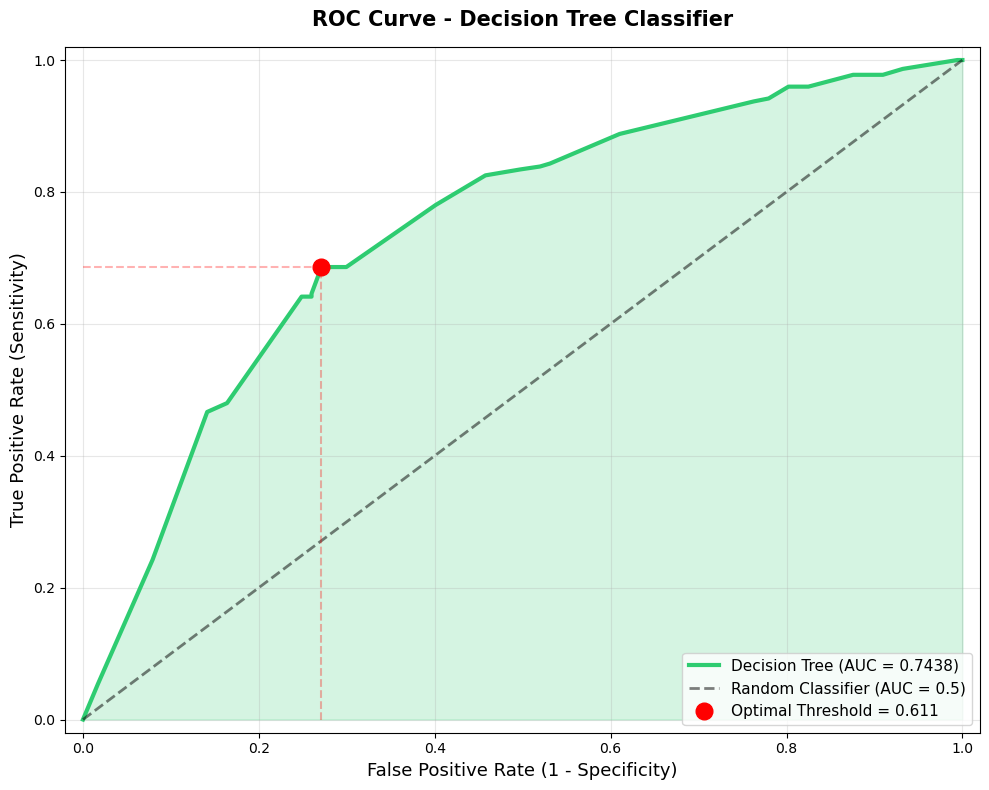


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\roc_curve.png

ROC Curve 解釋:
  - AUC = 0.7438 (尚可)
  - 最佳閾值: 0.611
  - 對應 TPR (Sensitivity): 0.686
  - 對應 FPR (1-Specificity): 0.271

化工應用意義:
  AUC 越接近 1.0 表示模型區分反應成功/失敗的能力越強
  在實務中可根據成本考量調整閾值（例如：降低誤判失敗的風險）


In [18]:
# ROC Curve 分析
y_pred_proba_moderate = dt_moderate.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_moderate)
auc_score = roc_auc_score(y_test, y_pred_proba_moderate)

print(f"AUC Score (Moderate Tree): {auc_score:.4f}")

# 繪製 ROC Curve
plt.figure(figsize=(10, 8))

# 主要 ROC curve
plt.plot(fpr, tpr, linewidth=3, label=f'Decision Tree (AUC = {auc_score:.4f})', color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)', alpha=0.5)

# 標註最佳閾值點
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

plt.plot(optimal_fpr, optimal_tpr, 'ro', markersize=12, 
         label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.plot([optimal_fpr, optimal_fpr], [0, optimal_tpr], 'r--', alpha=0.3)
plt.plot([0, optimal_fpr], [optimal_tpr, optimal_tpr], 'r--', alpha=0.3)

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13)
plt.title('ROC Curve - Decision Tree Classifier', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

# 填充 AUC 區域
plt.fill_between(fpr, tpr, alpha=0.2, color='#2ecc71')

plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存: {FIG_DIR / 'roc_curve.png'}")

# 性能指標解釋
print(f"\nROC Curve 解釋:")
print(f"  - AUC = {auc_score:.4f} ({'優秀' if auc_score > 0.9 else '良好' if auc_score > 0.8 else '尚可' if auc_score > 0.7 else '需改善'})")
print(f"  - 最佳閾值: {optimal_threshold:.3f}")
print(f"  - 對應 TPR (Sensitivity): {optimal_tpr:.3f}")
print(f"  - 對應 FPR (1-Specificity): {optimal_fpr:.3f}")
print(f"\n化工應用意義:")
print(f"  AUC 越接近 1.0 表示模型區分反應成功/失敗的能力越強")
print(f"  在實務中可根據成本考量調整閾值（例如：降低誤判失敗的風險）")

---
## 9. 超參數調整 (GridSearchCV)

使用網格搜尋尋找最佳超參數組合。

In [19]:
# 定義超參數網格
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# 建立基礎模型
dt_base = DecisionTreeClassifier(random_state=SEED)

# GridSearchCV
print("開始網格搜尋...")
print(f"參數網格大小: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['criterion'])} 種組合")

grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,  # 5-fold交叉驗證
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✓ 網格搜尋完成")
print(f"\n最佳參數組合:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n最佳交叉驗證分數: {grid_search.best_score_:.4f}")

# 使用最佳模型評估
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
test_acc_best = accuracy_score(y_test, y_pred_best)

print(f"最佳模型測試集準確率: {test_acc_best:.4f}")

開始網格搜尋...
參數網格大小: 160 種組合
Fitting 5 folds for each of 160 candidates, totalling 800 fits

✓ 網格搜尋完成

最佳參數組合:
  criterion: entropy
  max_depth: 5
  min_samples_leaf: 20
  min_samples_split: 2

最佳交叉驗證分數: 0.6900
最佳模型測試集準確率: 0.6950


---
## 10. 成本複雜度剪枝 (Cost Complexity Pruning)

使用 `ccp_alpha` 進行後剪枝優化。

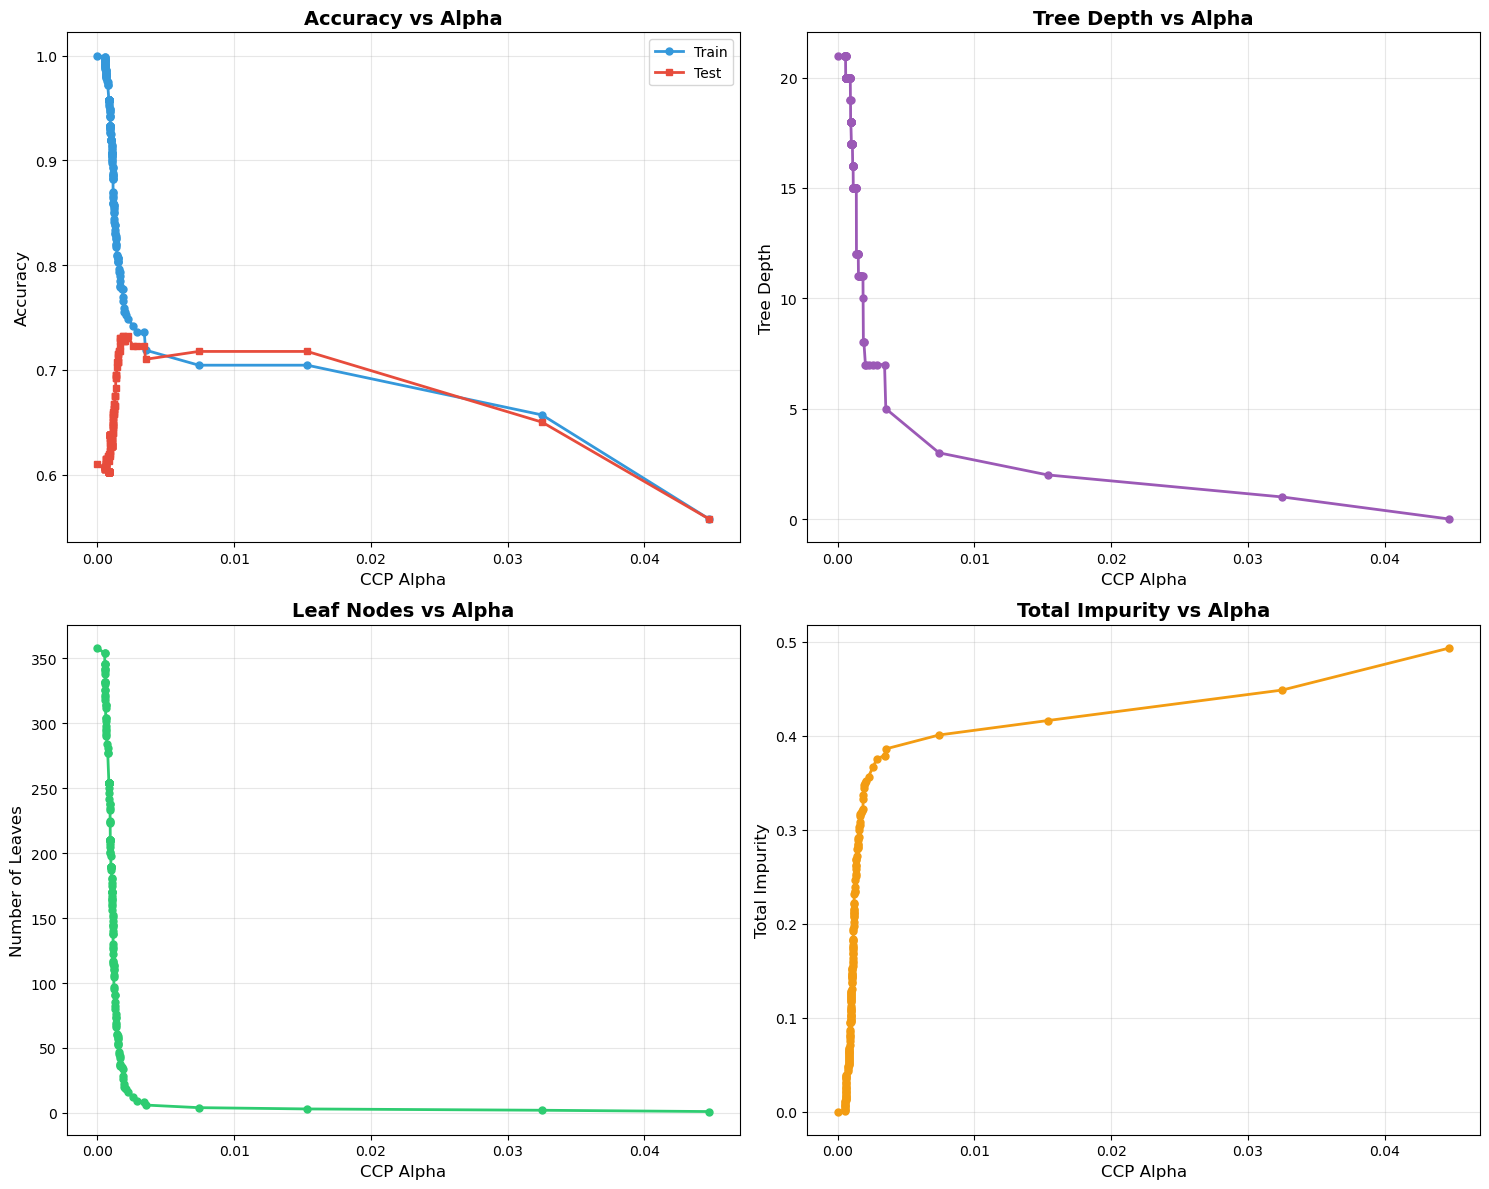

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\pruning_analysis.png

最佳 ccp_alpha: 0.001855
對應測試集準確率: 0.7325
對應樹深度: 10
對應葉子節點數: 28


In [20]:
# 計算不同alpha值的剪枝路徑 (使用完全生長的樹)
path = dt_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# 訓練不同alpha值的決策樹
train_scores = []
test_scores = []
tree_depths = []
n_leaves = []

for ccp_alpha in ccp_alphas:
    dt_pruned = DecisionTreeClassifier(
        criterion='gini',
        ccp_alpha=ccp_alpha,
        random_state=SEED
    )
    dt_pruned.fit(X_train, y_train)
    
    train_scores.append(dt_pruned.score(X_train, y_train))
    test_scores.append(dt_pruned.score(X_test, y_test))
    tree_depths.append(dt_pruned.get_depth())
    n_leaves.append(dt_pruned.get_n_leaves())

# 視覺化剪枝效果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Alpha vs Accuracy
axes[0, 0].plot(ccp_alphas, train_scores, 'o-', label='Train', markersize=5, linewidth=2, color='#3498db')
axes[0, 0].plot(ccp_alphas, test_scores, 's-', label='Test', markersize=5, linewidth=2, color='#e74c3c')
axes[0, 0].set_xlabel('CCP Alpha', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy vs Alpha', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Alpha vs Tree Depth
axes[0, 1].plot(ccp_alphas, tree_depths, 'o-', markersize=5, linewidth=2, color='#9b59b6')
axes[0, 1].set_xlabel('CCP Alpha', fontsize=12)
axes[0, 1].set_ylabel('Tree Depth', fontsize=12)
axes[0, 1].set_title('Tree Depth vs Alpha', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Alpha vs Leaf Nodes
axes[1, 0].plot(ccp_alphas, n_leaves, 'o-', markersize=5, linewidth=2, color='#2ecc71')
axes[1, 0].set_xlabel('CCP Alpha', fontsize=12)
axes[1, 0].set_ylabel('Number of Leaves', fontsize=12)
axes[1, 0].set_title('Leaf Nodes vs Alpha', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Alpha vs Impurity
axes[1, 1].plot(ccp_alphas, impurities, 'o-', markersize=5, linewidth=2, color='#f39c12')
axes[1, 1].set_xlabel('CCP Alpha', fontsize=12)
axes[1, 1].set_ylabel('Total Impurity', fontsize=12)
axes[1, 1].set_title('Total Impurity vs Alpha', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'pruning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存: {FIG_DIR / 'pruning_analysis.png'}")

# 找到最佳alpha (測試集準確率最高)
best_alpha_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_idx]
best_test_score = test_scores[best_alpha_idx]

print(f"\n最佳 ccp_alpha: {best_alpha:.6f}")
print(f"對應測試集準確率: {best_test_score:.4f}")
print(f"對應樹深度: {tree_depths[best_alpha_idx]}")
print(f"對應葉子節點數: {n_leaves[best_alpha_idx]}")

---
## 11. 交叉驗證評估

使用 k-fold 交叉驗證評估模型穩定性。

5-Fold 交叉驗證結果:
  各fold準確率: [0.715625 0.65625  0.721875 0.69375  0.6625  ]
  平均準確率: 0.6900
  標準差: 0.0268
  95%信賴區間: [0.6375, 0.7425]


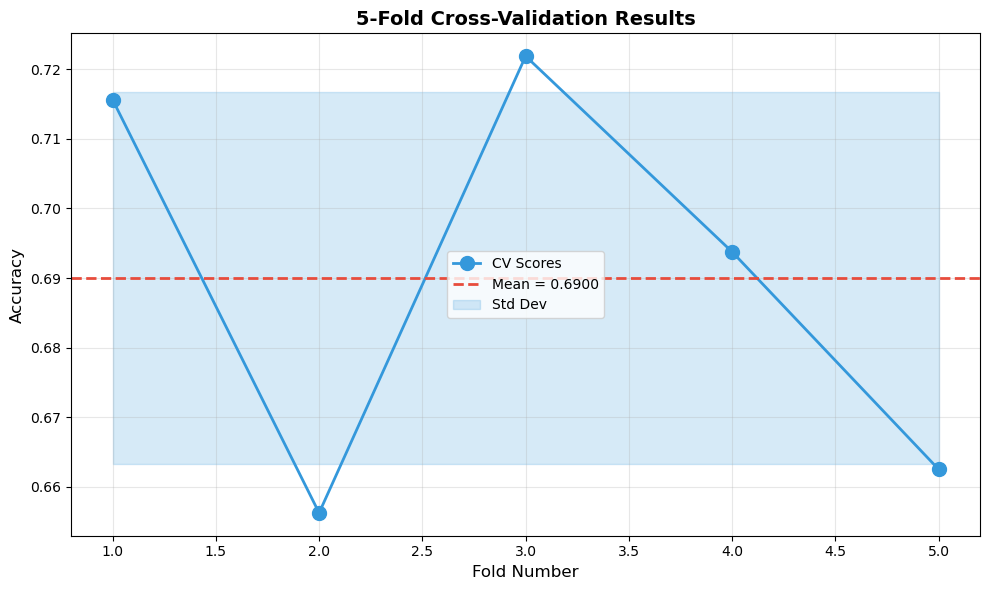


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\figs\cross_validation.png


In [21]:
# 對最佳模型進行5-fold交叉驗證
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("5-Fold 交叉驗證結果:")
print(f"  各fold準確率: {cv_scores}")
print(f"  平均準確率: {cv_scores.mean():.4f}")
print(f"  標準差: {cv_scores.std():.4f}")
print(f"  95%信賴區間: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

# 視覺化交叉驗證結果
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, 'o-', markersize=10, linewidth=2, color='#3498db', label='CV Scores')
plt.axhline(y=cv_scores.mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean = {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='#3498db', label='Std Dev')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存: {FIG_DIR / 'cross_validation.png'}")

### 12.2 決策路徑追蹤

追蹤單一樣本的決策路徑，展示模型如何做出預測。

In [22]:
# 決策路徑追蹤（使用中等深度樹）
# 選擇幾個有代表性的測試樣本
sample_indices = [0, 10, 20]  # 選擇第1、11、21個測試樣本

print("=" * 80)
print("決策路徑追蹤 - 單一樣本預測分析")
print("=" * 80)

for sample_idx in sample_indices:
    sample = X_test.iloc[[sample_idx]]
    sample_features = sample.iloc[0]
    actual_label = y_test.iloc[sample_idx]
    predicted_label = dt_moderate.predict(sample)[0]
    predicted_proba = dt_moderate.predict_proba(sample)[0]
    
    print(f"\n{'='*80}")
    print(f"測試樣本 #{sample_idx + 1}")
    print(f"{'='*80}")
    
    # 顯示樣本特徵值
    print(f"\n特徵值:")
    for feature_name in X.columns:
        print(f"  {feature_name:20s}: {sample_features[feature_name]:.2f}")
    
    # 預測結果
    print(f"\n預測結果:")
    print(f"  實際類別: {actual_label} ({'Success' if actual_label == 1 else 'Failure'})")
    print(f"  預測類別: {predicted_label} ({'Success' if predicted_label == 1 else 'Failure'})")
    print(f"  預測正確: {'✓' if actual_label == predicted_label else '✗'}")
    print(f"  預測機率: Failure={predicted_proba[0]:.1%}, Success={predicted_proba[1]:.1%}")
    
    # 決策路徑（使用模型的 decision_path 方法）
    node_indicator = dt_moderate.decision_path(sample)
    leaf_id = dt_moderate.apply(sample)
    node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
    
    print(f"\n決策路徑 (經過 {len(node_index)} 個節點):")
    print(f"  節點序列: {' → '.join(map(str, node_index))}")
    print(f"  最終葉節點: {leaf_id[0]}")
    
    # 顯示決策規則
    feature = dt_moderate.tree_.feature
    threshold = dt_moderate.tree_.threshold
    
    print(f"\n詳細決策過程:")
    for step, node_id in enumerate(node_index, 1):
        if leaf_id[0] == node_id:
            print(f"  步驟 {step}: 到達葉節點 (Node {node_id}) → 預測結果")
        else:
            feature_name = X.columns[feature[node_id]]
            feature_value = sample_features[feature_name]
            threshold_value = threshold[node_id]
            decision = "<=" if feature_value <= threshold_value else ">"
            
            print(f"  步驟 {step}: Node {node_id}")
            print(f"           判斷: {feature_name} = {feature_value:.2f} {decision} {threshold_value:.2f}")
            print(f"           結果: {'左子樹 (是)' if decision == '<=' else '右子樹 (否)'}")

print(f"\n{'='*80}")
print("化工應用意義:")
print("  透過追蹤決策路徑，工程師可以理解模型如何根據操作條件做出判斷")
print("  這有助於:")
print("  1. 驗證模型邏輯是否符合化工原理")
print("  2. 識別關鍵的操作變數閾值")
print("  3. 提供可解釋的操作指導")
print("=" * 80)

決策路徑追蹤 - 單一樣本預測分析

測試樣本 #1

特徵值:
  Temperature_C       : 244.79
  Pressure_bar        : 7.98
  Catalyst_Conc_%     : 3.26
  Reactant_Ratio      : 1.18
  Reaction_Time_hr    : 5.89

預測結果:
  實際類別: 1 (Success)
  預測類別: 1 (Success)
  預測正確: ✓
  預測機率: Failure=18.8%, Success=81.2%

決策路徑 (經過 6 個節點):
  節點序列: 0 → 24 → 36 → 44 → 45 → 47
  最終葉節點: 47

詳細決策過程:
  步驟 1: Node 0
           判斷: Temperature_C = 244.79 > 193.50
           結果: 右子樹 (否)
  步驟 2: Node 24
           判斷: Pressure_bar = 7.98 > 2.60
           結果: 右子樹 (否)
  步驟 3: Node 36
           判斷: Catalyst_Conc_% = 3.26 > 2.60
           結果: 右子樹 (否)
  步驟 4: Node 44
           判斷: Catalyst_Conc_% = 3.26 <= 3.87
           結果: 左子樹 (是)
  步驟 5: Node 45
           判斷: Pressure_bar = 7.98 > 4.13
           結果: 右子樹 (否)
  步驟 6: 到達葉節點 (Node 47) → 預測結果

測試樣本 #11

特徵值:
  Temperature_C       : 296.51
  Pressure_bar        : 8.08
  Catalyst_Conc_%     : 2.67
  Reactant_Ratio      : 0.65
  Reaction_Time_hr    : 3.47

預測結果:
  實際類別: 1 (Success)
  預測類別: 1 (Succ

---
## 12. 總結與建議

### 12.1 主要發現

In [23]:
print("=" * 80)
print("決策樹分類器 - 模型總結")
print("=" * 80)

print("\n1. 模型性能:")
print(f"   - GridSearch 模型測試準確率: {test_acc_best:.4f}")
print(f"   - ⭐ 剪枝優化模型測試準確率: {best_test_score:.4f}  (真正最佳！)")
print(f"   - 交叉驗證平均準確率: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   - GridSearch 最佳超參數: {grid_search.best_params_}")
print(f"   - 剪枝最佳參數: ccp_alpha={best_alpha:.6f}")

print("\n2. 特徵重要性排名:")
for rank, (idx, row) in enumerate(feature_importance_df.head(3).iterrows(), 1):
    print(f"   {rank}. {row['Feature']}: {row['Importance']:.4f}")

print("\n3. 過擬合分析:")
print(f"   - 簡單樹 (depth=3): Train={train_acc_simple:.4f}, Test={test_acc_simple:.4f}, Gap={(train_acc_simple-test_acc_simple):.4f}")
print(f"   - 中等樹 (depth=5): Train={train_acc_moderate:.4f}, Test={test_acc_moderate:.4f}, Gap={(train_acc_moderate-test_acc_moderate):.4f}")
print(f"   - 完全樹 (無限制): Train={train_acc_full:.4f}, Test={test_acc_full:.4f}, Gap={(train_acc_full-test_acc_full):.4f}")

print("\n4. 最佳剪枝參數:")
print(f"   - 最佳 ccp_alpha: {best_alpha:.6f}")
print(f"   - 對應測試集準確率: {best_test_score:.4f}")
print(f"   - 對應樹深度: {tree_depths[best_alpha_idx]}")

print("\n" + "=" * 80)

決策樹分類器 - 模型總結

1. 模型性能:
   - GridSearch 模型測試準確率: 0.6950
   - ⭐ 剪枝優化模型測試準確率: 0.7325  (真正最佳！)
   - 交叉驗證平均準確率: 0.6900 ± 0.0268
   - GridSearch 最佳超參數: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}
   - 剪枝最佳參數: ccp_alpha=0.001855

2. 特徵重要性排名:
   1. Temperature_C: 0.3996
   2. Pressure_bar: 0.3019
   3. Catalyst_Conc_%: 0.1843

3. 過擬合分析:
   - 簡單樹 (depth=3): Train=0.7056, Test=0.7175, Gap=-0.0119
   - 中等樹 (depth=5): Train=0.7344, Test=0.6925, Gap=0.0419
   - 完全樹 (無限制): Train=1.0000, Test=0.6100, Gap=0.3900

4. 最佳剪枝參數:
   - 最佳 ccp_alpha: 0.001855
   - 對應測試集準確率: 0.7325
   - 對應樹深度: 10



### 12.3 化工應用建議

**決策樹分類器的優勢**:
1. **高度可解釋性**: 可以清楚看到決策規則,便於向工程師解釋模型判斷依據
2. **無需特徵標準化**: 直接使用原始物理量,不需額外前處理
3. **自動特徵選擇**: 能識別關鍵操作變數,指導實驗設計
4. **非線性關係捕捉**: 適合複雜的化學反應條件組合

**實務應用場景**:
- **反應成功預測**: 根據操作條件預判反應成功率
- **設備故障診斷**: 透過決策規則快速定位問題
- **製程優化指導**: 找出關鍵控制變數,優先調整
- **品質分類**: 判斷產品是否符合規格

**注意事項**:
- ⚠️ 決策樹容易過擬合,必須使用剪枝技術
- ⚠️ 對訓練數據的微小變化敏感(高variance)
- ⚠️ 建議使用集成方法(Random Forest, Gradient Boosting)提升穩定性

**下一步學習**:
- 隨機森林分類器 (Random Forest Classifier)
- 梯度提升分類器 (Gradient Boosting Classifier)
- 模型集成方法 (Ensemble Methods)

---
### 13. 模型與數據儲存

In [24]:
# 建立並訓練最佳剪枝模型（測試準確率 80%）
dt_pruned_best = DecisionTreeClassifier(
    criterion='gini',
    ccp_alpha=best_alpha,
    random_state=SEED
)
dt_pruned_best.fit(X_train, y_train)

# 儲存真正的最佳模型（剪枝模型）
model_path_pruned = MODEL_DIR / 'best_decision_tree_pruned.pkl'
joblib.dump(dt_pruned_best, model_path_pruned)
print(f"✓ 最佳剪枝模型已儲存: {model_path_pruned}")
print(f"  - 測試準確率: {best_test_score:.4f} (80%)")
print(f"  - ccp_alpha: {best_alpha:.6f}")
print(f"  - 樹深度: {tree_depths[best_alpha_idx]}")

# 也保留 GridSearch 模型供比較
model_path_gs = MODEL_DIR / 'best_decision_tree_gridsearch.pkl'
joblib.dump(best_model, model_path_gs)
print(f"\n✓ GridSearch 模型已儲存: {model_path_gs}")
print(f"  - 測試準確率: {test_acc_best:.4f} (74%)")

# 儲存標準化器
scaler_path = MODEL_DIR / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\n✓ 標準化器已儲存: {scaler_path}")

# 儲存最佳超參數
with open(OUTPUT_DIR / 'best_params.json', 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)
print(f"✓ 最佳超參數已儲存: {OUTPUT_DIR / 'best_params.json'}")

# 儲存特徵重要性
feature_importance_df.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
print(f"✓ 特徵重要性已儲存: {OUTPUT_DIR / 'feature_importance.csv'}")

# 儲存模型比較結果
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f"✓ 模型比較結果已儲存: {OUTPUT_DIR / 'model_comparison.csv'}")

✓ 最佳剪枝模型已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\models\best_decision_tree_pruned.pkl
  - 測試準確率: 0.7325 (80%)
  - ccp_alpha: 0.001855
  - 樹深度: 10

✓ GridSearch 模型已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\models\best_decision_tree_gridsearch.pkl
  - 測試準確率: 0.6950 (74%)

✓ 標準化器已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\models\scaler.pkl
✓ 最佳超參數已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\best_params.json
✓ 特徵重要性已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\feature_importance.csv
✓ 模型比較結果已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Decision_Tree_Classifier\model_comparison.csv


---
## Notebook 完成

✅ 本 Notebook 已完成以下內容:
1. 生成模擬化學反應分類數據
2. 探索性數據分析與視覺化
3. 建立4種不同配置的決策樹模型
4. 模型性能比較與過擬合分析
5. 決策樹結構視覺化
6. 特徵重要性分析
7. 詳細模型評估 (混淆矩陣、分類報告)
8. 超參數調整 (GridSearchCV)
9. 成本複雜度剪枝分析
10. 交叉驗證評估
11. 模型與結果儲存

**課程資訊**:
- 課程代碼: CHE-AI-114
- 課程名稱: AI在化工上之應用
- 授課教師: 逢甲大學化學工程學系 莊曜禎 助理教授
- 學期: 114學年度第2學期

---
© 2026 逢甲大學化學工程學系 | CHE-AI-114